# Getting Started
In this post, we'll demonstrate some of the core functionality of the **SDMetrics** library by using it to evaluate a synthetic dataset.

## Generating Synthetic Datasets
The **SDV** library provides tools for generating synthetic relational databases. Let's start by loading the Walmart dataset and generating a synthetic copy with 20 rows in the root table.

In [1]:
from sdv import load_demo

metadata, real_tables = load_demo("walmart", metadata=True)
for table_name, df in real_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

> stores
 Store Type    Size
     1    A  151315
     2    A  202307
     3    B   37392
     4    A  205863
     5    B   34875

> features
 Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday
     1 2010-02-05        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106      False
     1 2010-02-12        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106       True
     1 2010-02-19        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106      False
     1 2010-02-26        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106      False
     1 2010-03-05        46.50       2.625        NaN        NaN        NaN        NaN        NaN  211.350143         8.106      False

> depts
 Store  Dept       Date  Weekly_Sales  I

In [2]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, real_tables)

synthetic_tables = sdv.sample_all(20)
for table_name, df in synthetic_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

/Users/kevz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


> stores
Type    Size  Store
   A  136019      0
   B  161965      1
   A  172436      2
   A  123278      3
   A  157759      4

> depts
                         Date  Weekly_Sales  Store  Dept  IsHoliday
2011-11-13 01:20:52.383595264  28228.944102      0   104      False
2009-11-10 21:41:59.829368320  -4865.654563      0    27      False
2012-04-11 21:56:54.126845184  29996.711646      0    29      False
2010-04-19 08:01:46.326443520  19070.903559      0    56      False
2011-05-09 14:29:55.166524672  18887.952724      0    43      False

> features
                         Date    MarkDown1  Store  IsHoliday  MarkDown4    MarkDown3  Fuel_Price  Unemployment  Temperature    MarkDown5    MarkDown2         CPI
2012-06-21 14:49:12.694771968          NaN      0      False        NaN          NaN    2.616784      6.666517    59.790618          NaN          NaN  201.083573
2011-06-24 00:31:24.721776128          NaN      0      False        NaN  2007.682469    2.972034      8.407531    54.9

## Evaluation with SDMetrics
Now that we have (1) a metadata object, (2) a set of real tables, and (3) a set of fake tables, we can pass them to **SDMetrics** for evaluation. The simplest way to get started with **SDMetrics** is to use the `evaluate` function which generates a report with the default metrics.

In [3]:
from sdmetrics import evaluate
report = evaluate(metadata, real_tables, synthetic_tables)
report

/Users/kevz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kevz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kevz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kevz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kevz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

The metrics report can provide an **overall score**. This is a single scalar value which you can pass to an optimization routine (i.e. to tune some hyperparameters in your model).

In [4]:
print(report.overall())

-44.4848254534212


Furthermore, the metrics report can also provide some key highlights. This shows the problem areas where your model performs especially poorly - for example, the below highlights suggest that our model is very bad at modeling the `MarkDownX` columns since the kstest has detected that the distributions look quite different between the real and synthetic versions.

In [5]:
report.highlights()

,Columns,Goal,Misc. Tags,Name,Tables,Unit,Value
0,column:Weekly_Sales,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:depts,p-value,0.000000e+00
1,column:Dept,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:depts,p-value,0.000000e+00
2,column:MarkDown1,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,1.635895e-13
3,column:MarkDown4,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,3.100767e-37
4,column:MarkDown3,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,1.724286e-143
5,column:Fuel_Price,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,2.259047e-21
6,column:Unemployment,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,1.817258e-45
7,column:Temperature,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,2.434418e-22
8,column:MarkDown5,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,1.620263e-10
9,column:MarkDown2,Goal.MAXIMIZE,"statistic:univariate,priority:high",kstest,table:features,p-value,1.899937e-103


In addition, you will also be able to generate a visualization of the metrics.

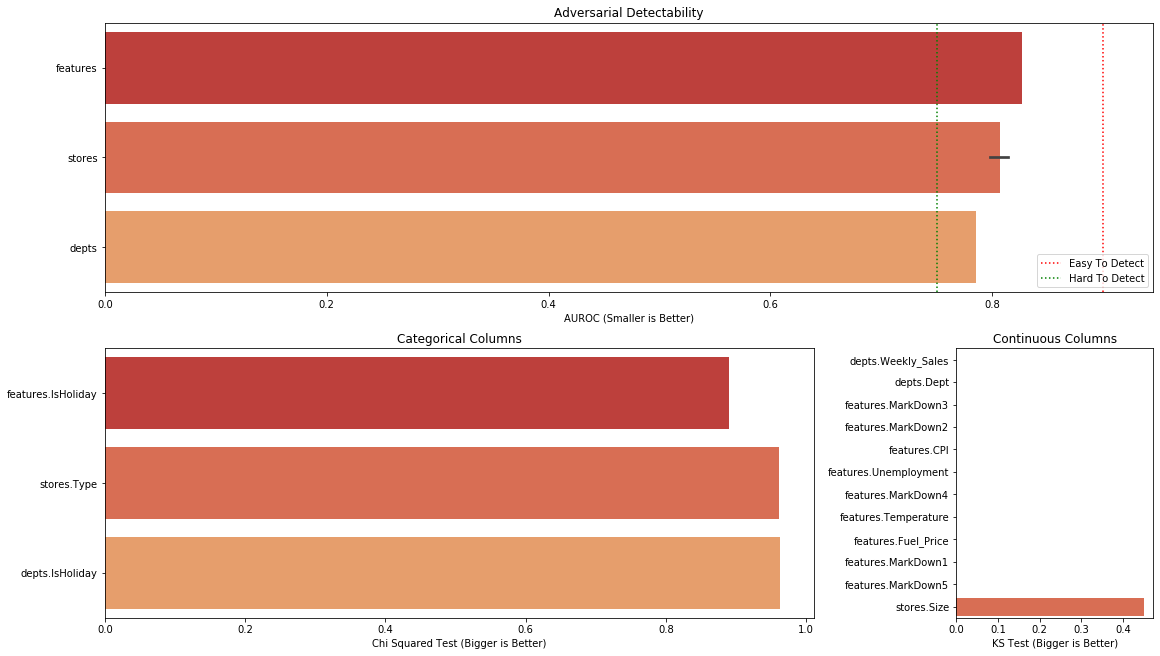

In [6]:
%matplotlib inline
report.visualize().savefig("../resources/visualize.png");

Finally, you can also print a detailed report containing all of the metrics that were computed.

In [7]:
report.details()

,Columns,Goal,Misc. Tags,Name,Tables,Unit,Value
0,,Goal.MAXIMIZE,child:depts,foreign-key,table:stores,binary,1.000000e+00
1,,Goal.MAXIMIZE,child:features,foreign-key,table:stores,binary,1.000000e+00
2,,Goal.MINIMIZE,detection:auroc,logistic,table:stores,auroc,8.015873e-01
3,,Goal.MINIMIZE,"child:depts,detection:auroc",logistic,table:stores,auroc,7.980783e-01
4,,Goal.MINIMIZE,"child:features,detection:auroc",logistic,table:stores,auroc,8.201162e-01
5,,Goal.MINIMIZE,detection:auroc,logistic,table:depts,auroc,7.853227e-01
6,,Goal.MINIMIZE,detection:auroc,logistic,table:features,auroc,8.270256e-01
7,column:Type,Goal.MAXIMIZE,statistic:univariate,chisquare,table:stores,p-value,9.610881e-01
8,column:IsHoliday,Goal.MAXIMIZE,statistic:univariate,chisquare,table:depts,p-value,9.631733e-01
9,column:IsHoliday,Goal.MAXIMIZE,statistic:univariate,chisquare,table:features,p-value,8.905500e-01
